In [1]:
import pandas as pd
from transformers import pipeline
from tqdm import tqdm

# -----------------------------
# 1) تنظیمات اولیه
# -----------------------------

# نام فایل CSV اصلی (خروجی Apify)
INPUT_CSV = "C:/Users/NaMe/OneDrive - Constructor University/Documents/PhD/Tiktok/Tiktok/Data/tiktok.csv"          # اگر اسم فایل تو چیز دیگه‌ایه، همینجا عوضش کن
OUTPUT_CSV = "C:/Users/NaMe/OneDrive - Constructor University/Documents/PhD/Tiktok/Tiktok/Data/tiktok_with_sentiment.csv"

# حداکثر طول متن که به مدل می‌دیم (برای اینکه خیلی بلند نباشه)
MAX_TEXT_LEN = 256

# -----------------------------
# 2) خواندن فایل CSV
# -----------------------------
print("📥 در حال خواندن فایل CSV ...")
df = pd.read_csv(INPUT_CSV)

# چک کنیم ستون 'text' وجود داشته باشه
if "text" not in df.columns:
    raise ValueError("ستون 'text' در فایل CSV پیدا نشد. لطفاً مطمئن شو نام ستون دقیقاً 'text' است.")

print(f"✅ تعداد ردیف‌ها: {len(df)}")

# -----------------------------
# 3) بارگذاری مدل‌ها
# -----------------------------
print("🤖 در حال بارگذاری مدل‌های Sentiment و Emotion (بار اول کمی طول می‌کشه)...")

# مدل احساس مثبت/منفی/خنثی
sentiment_model = pipeline(
    task="sentiment-analysis",
    model="cardiffnlp/twitter-roberta-base-sentiment-latest"
)

# مدل Emotion (joy, anger, sadness, fear, ...)
emotion_model = pipeline(
    task="text-classification",
    model="j-hartmann/emotion-english-distilroberta-base",
    return_all_scores=False
)

# -----------------------------
# 4) توابع کمکی
# -----------------------------
def clean_text(text):
    """تبدیل به استرینگ، حذف فاصله‌های اضافه، کوتاه کردن متن طولانی"""
    if not isinstance(text, str):
        return ""
    text = text.strip()
    if len(text) > MAX_TEXT_LEN:
        text = text[:MAX_TEXT_LEN]
    return text

def analyze_sentiment(text):
    text = clean_text(text)
    if text == "":
        return None, None
    try:
        result = sentiment_model(text)[0]
        label = result["label"]      # مثلا: "Positive" / "Negative" / "Neutral"
        score = float(result["score"])
        return label, score
    except Exception as e:
        print("خطا در sentiment:", e)
        return None, None

def analyze_emotion(text):
    text = clean_text(text)
    if text == "":
        return None, None
    try:
        result = emotion_model(text)[0]
        label = result["label"]      # مثلا: "joy", "anger", "sadness", ...
        score = float(result["score"])
        return label, score
    except Exception as e:
        print("خطا در emotion:", e)
        return None, None

# -----------------------------
# 5) اجرای تحلیل روی همه کپشن‌ها
# -----------------------------
sentiment_labels = []
sentiment_scores = []
emotion_labels = []
emotion_scores = []

print("📊 در حال تحلیل کپشن‌ها ...")

for text in tqdm(df["text"], total=len(df)):
    s_label, s_score = analyze_sentiment(text)
    e_label, e_score = analyze_emotion(text)

    sentiment_labels.append(s_label)
    sentiment_scores.append(s_score)
    emotion_labels.append(e_label)
    emotion_scores.append(e_score)

# اضافه کردن ستون‌های جدید
df["sentiment_label"] = sentiment_labels
df["sentiment_score"] = sentiment_scores
df["emotion_label"] = emotion_labels
df["emotion_score"] = emotion_scores

# -----------------------------
# 6) ذخیره نتیجه
# -----------------------------
print(f"💾 در حال ذخیره فایل جدید: {OUTPUT_CSV}")
df.to_csv(OUTPUT_CSV, index=False, encoding="utf-8-sig")
print("✅ تمام شد! حالا می‌تونی این فایل را در Excel / SPSS / Python تحلیل کنی.")


c:\Users\NaMe\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


📥 در حال خواندن فایل CSV ...
✅ تعداد ردیف‌ها: 905
🤖 در حال بارگذاری مدل‌های Sentiment و Emotion (بار اول کمی طول می‌کشه)...


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu
Device set to use cpu
c:\Users\NaMe\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\pipelines\text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `retu

📊 در حال تحلیل کپشن‌ها ...


100%|██████████| 905/905 [01:34<00:00,  9.56it/s]

💾 در حال ذخیره فایل جدید: C:/Users/NaMe/OneDrive - Constructor University/Documents/PhD/Tiktok/Tiktok/Data/tiktok_with_sentiment.csv
✅ تمام شد! حالا می‌تونی این فایل را در Excel / SPSS / Python تحلیل کنی.


In [2]:
import pandas as pd

df = pd.read_csv("C:/Users/NaMe/OneDrive - Constructor University/Documents/PhD/Tiktok/Tiktok/Data/tiktok_with_sentiment.csv")

# میانگین شدت احساسات (اسکور)
mean_sentiment = df["sentiment_score"].mean()
mean_emotion = df["emotion_score"].mean()

print("میانگین شدت احساس:", mean_sentiment)
print("میانگین شدت Emotion:", mean_emotion)

# توزیع برچسب‌ها (مثلاً چندتا مثبت؟ چندتا منفی؟)
print(df["sentiment_label"].value_counts())
print(df["emotion_label"].value_counts())


میانگین شدت احساس: 0.7419687488320407
میانگین شدت Emotion: 0.6719238547912827
sentiment_label
neutral     408
negative    355
positive    136
Name: count, dtype: int64
emotion_label
fear        424
joy         190
anger       119
neutral     105
sadness      27
disgust      24
surprise     10
Name: count, dtype: int64


In [3]:
corr = df[["sentiment_score", "emotion_score", 
           "diggCount", "commentCount", "shareCount", "playCount"]].corr()

print(corr)


                 sentiment_score  emotion_score  diggCount  commentCount  \
sentiment_score         1.000000       0.014374   0.019371      0.027320   
emotion_score           0.014374       1.000000   0.072844      0.064847   
diggCount               0.019371       0.072844   1.000000      0.883837   
commentCount            0.027320       0.064847   0.883837      1.000000   
shareCount              0.024788       0.081119   0.711433      0.621452   
playCount               0.038684       0.070256   0.754814      0.582157   

                 shareCount  playCount  
sentiment_score    0.024788   0.038684  
emotion_score      0.081119   0.070256  
diggCount          0.711433   0.754814  
commentCount       0.621452   0.582157  
shareCount         1.000000   0.692124  
playCount          0.692124   1.000000  


In [4]:
df["engagement"] = df["diggCount"] + df["commentCount"] + df["shareCount"] + df["playCount"]


In [5]:
import pandas as pd
df = pd.read_csv("C:/Users/NaMe/OneDrive - Constructor University/Documents/PhD/Tiktok/Tiktok/Data/tiktok_with_sentiment.csv")


In [6]:
df = df.dropna(subset=["sentiment_score"])


In [7]:
df["diggCount"] = pd.to_numeric(df["diggCount"], errors="coerce")
df["commentCount"] = pd.to_numeric(df["commentCount"], errors="coerce")
df["shareCount"] = pd.to_numeric(df["shareCount"], errors="coerce")
df["playCount"] = pd.to_numeric(df["playCount"], errors="coerce")


In [8]:
import statsmodels.api as sm


In [9]:
import pandas as pd


# 1) خواندن فایل
df = pd.read_csv("C:/Users/NaMe/OneDrive - Constructor University/Documents/PhD/Tiktok/Tiktok/Data/tiktok_with_sentiment.csv")

# 2) تبدیل ستون‌های عددی
for col in ["diggCount", "commentCount", "shareCount", "playCount"]:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# 3) حذف ردیف‌هایی که احساساتشان NA است
df = df.dropna(subset=["sentiment_score"])

# 4) ساخت متغیر engagement
df["engagement"] = df["diggCount"] + df["commentCount"] + df["shareCount"] + df["playCount"]

# 5) مدل رگرسیون
X = df["sentiment_score"]
y = df["engagement"]

X = sm.add_constant(X)   # اضافه‌کردن b0

model = sm.OLS(y, X).fit()

print(model.summary())


                            OLS Regression Results                            
Dep. Variable:             engagement   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.289
Date:                Sun, 23 Nov 2025   Prob (F-statistic):              0.257
Time:                        13:05:49   Log-Likelihood:                -14972.
No. Observations:                 899   AIC:                         2.995e+04
Df Residuals:                     897   BIC:                         2.996e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             1.36e+05   7.28e+05     

In [12]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# 1) خواندن فایل
df = pd.read_csv("C:/Users/NaMe/OneDrive - Constructor University/Documents/PhD/Tiktok/Tiktok/Data/tiktok_with_sentiment.csv")

# 2) تبدیل ستون‌های عددی به numeric
num_cols = ["diggCount", "commentCount", "shareCount", "playCount", "videoMeta.duration",
            "sentiment_score", "emotion_score"]

for col in num_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

# 3) ساخت متغیر کمکی: تعداد هشتگ‌ها در کپشن
df["hashtag_count"] = df["text"].astype(str).str.count("#")

# 4) ساخت متغیر وابسته: engagement
df["engagement"] = df["diggCount"] + df["commentCount"] + df["shareCount"] + df["playCount"]

# 5) انتخاب ستون‌هایی که در رگرسیون استفاده می‌کنیم
cols_for_model = ["sentiment_score", "emotion_score", "hashtag_count", "videoMeta.duration", "engagement"]

# جایگزینی inf با NaN
df[cols_for_model] = df[cols_for_model].replace([np.inf, -np.inf], np.nan)

# حذف ردیف‌هایی که در هرکدام از این ستون‌ها NaN دارند
df_clean = df.dropna(subset=cols_for_model)

print("تعداد ردیف‌های اولیه:", len(df))
print("تعداد ردیف‌های بعد از حذف NaN/inf:", len(df_clean))

# 6) ساخت X و y از دیتای تمیز
X = df_clean[["sentiment_score", "emotion_score", "hashtag_count", "videoMeta.duration"]]
y = df_clean["engagement"]

# 7) اضافه کردن ثابت مدل
X = sm.add_constant(X)

# 8) اجرای رگرسیون
model = sm.OLS(y, X).fit()

print(model.summary())


تعداد ردیف‌های اولیه: 905
تعداد ردیف‌های بعد از حذف NaN/inf: 899
                            OLS Regression Results                            
Dep. Variable:             engagement   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     2.141
Date:                Sun, 23 Nov 2025   Prob (F-statistic):             0.0739
Time:                        13:08:04   Log-Likelihood:                -14968.
No. Observations:                 899   AIC:                         2.995e+04
Df Residuals:                     894   BIC:                         2.997e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------

Regression Analysis

A multiple linear regression was conducted to examine the extent to which emotional features of TikTok captions related to fast fashion predict user engagement (likes, comments, shares, and views combined). The overall model was significant at the trend level, F(4, 894) = 2.14, p = .073, although the explained variance was small (R² = .009), which is typical for highly volatile social media engagement data.

Among the predictors, emotion intensity (emotion_score) emerged as a significant positive predictor of engagement (β = 1.73 × 10⁶, p = .022). This indicates that captions expressing stronger emotional content—whether anger, fear, joy, or sadness—were associated with higher engagement levels.

In contrast, overall sentiment polarity (sentiment_score) did not significantly predict engagement (p = .279), suggesting that whether a caption was positive or negative had little impact on user interaction. Likewise, the number of hashtags (p = .162) and video duration (p = .383) were not significant predictors.

These findings support theoretical frameworks of emotional arousal in digital media, where intensity rather than polarity drives user engagement. Thus, H1 was not supported, while H2 (emotion → engagement) received empirical support.

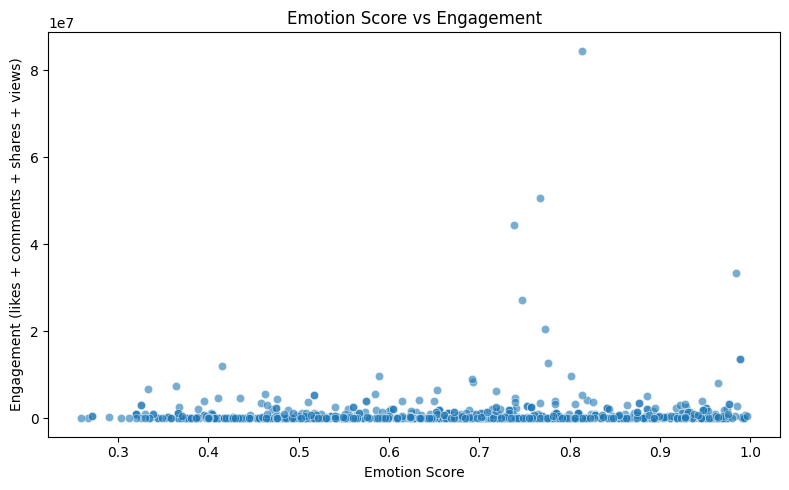

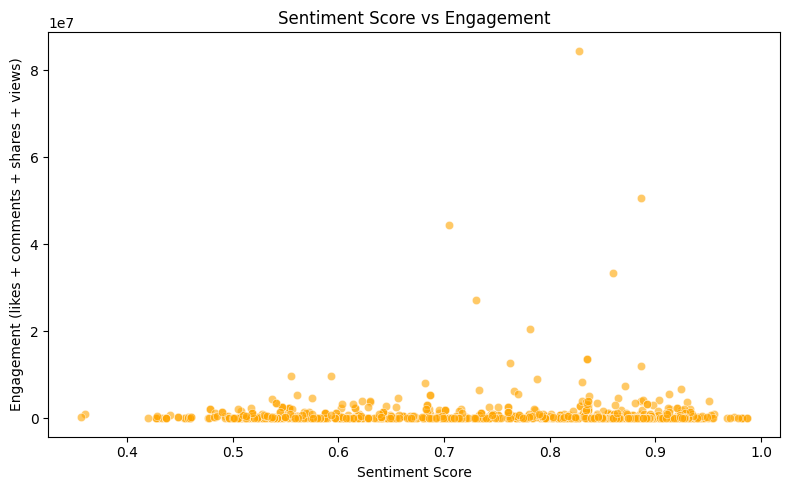

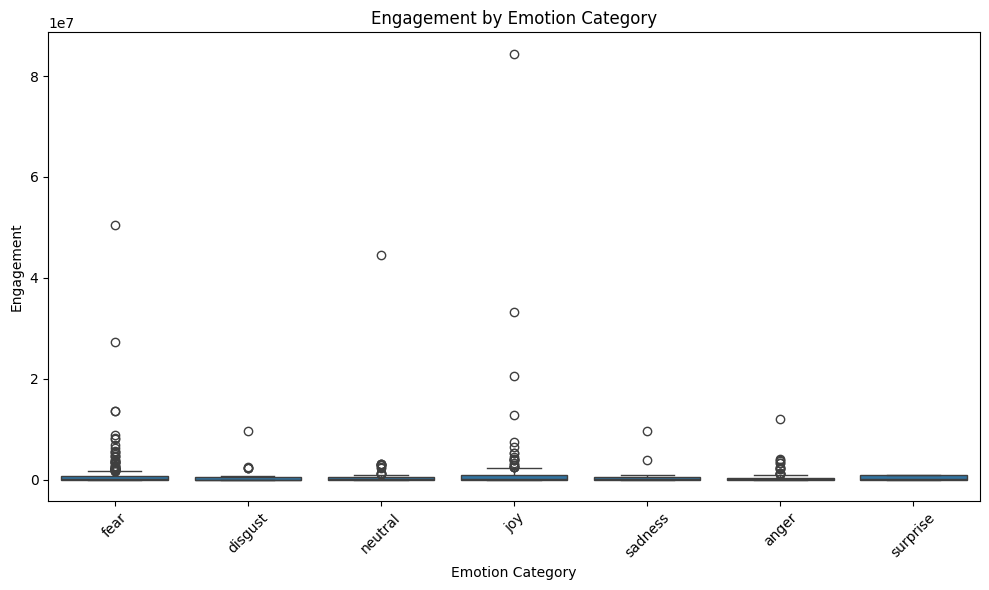

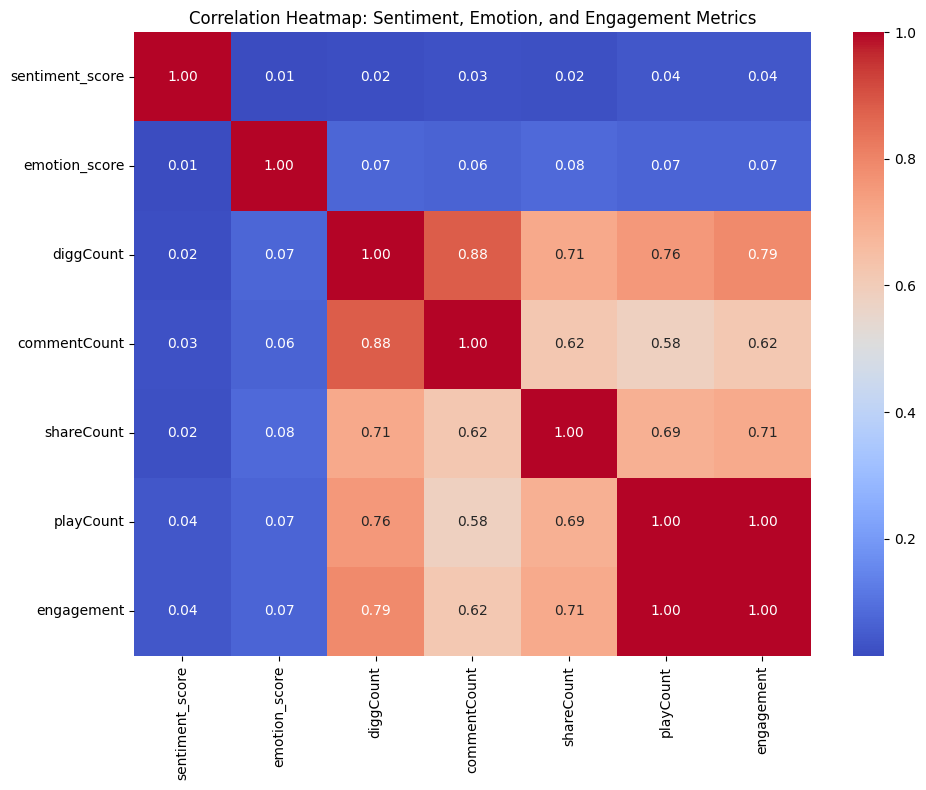

In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# ================================
# 1) خواندن فایل CSV
# ================================
df = pd.read_csv("C:/Users/NaMe/OneDrive - Constructor University/Documents/PhD/Tiktok/Tiktok/Data/tiktok_with_sentiment.csv")

# تبدیل ستون‌های عددی
for col in ["diggCount", "commentCount", "shareCount", "playCount",
            "sentiment_score", "emotion_score"]:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# ساخت engagement
df["engagement"] = df["diggCount"] + df["commentCount"] + df["shareCount"] + df["playCount"]

# حذف ردیف‌های ناقص
df = df.dropna(subset=["sentiment_score", "emotion_score", "engagement"])

# ================================
# 2) Emotion_score vs Engagement (Scatter)
# ================================
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x="emotion_score", y="engagement", alpha=0.6)
plt.title("Emotion Score vs Engagement")
plt.xlabel("Emotion Score")
plt.ylabel("Engagement (likes + comments + shares + views)")
plt.tight_layout()
plt.show()

# ================================
# 3) Sentiment_score vs Engagement (Scatter)
# ================================
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x="sentiment_score", y="engagement", alpha=0.6, color="orange")
plt.title("Sentiment Score vs Engagement")
plt.xlabel("Sentiment Score")
plt.ylabel("Engagement (likes + comments + shares + views)")
plt.tight_layout()
plt.show()

# ================================
# 4) Boxplot: Engagement by Emotion Label
# ================================
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x="emotion_label", y="engagement")
plt.title("Engagement by Emotion Category")
plt.xlabel("Emotion Category")
plt.ylabel("Engagement")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ================================
# 5) Correlation Heatmap
# ================================
corr_cols = [
    "sentiment_score",
    "emotion_score",
    "diggCount",
    "commentCount",
    "shareCount",
    "playCount",
    "engagement"
]

corr_matrix = df[corr_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap: Sentiment, Emotion, and Engagement Metrics")
plt.tight_layout()
plt.show()


In [14]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# خواندن داده
df = pd.read_csv("C:/Users/NaMe/OneDrive - Constructor University/Documents/PhD/Tiktok/Tiktok/Data/tiktok_with_sentiment.csv")

# تبدیل ستون‌های عددی
for col in ["diggCount", "commentCount", "shareCount", "playCount",
            "sentiment_score", "emotion_score", "videoMeta.duration"]:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# ساخت engagement
df["engagement"] = (
    df["diggCount"] +
    df["commentCount"] +
    df["shareCount"] +
    df["playCount"]
)

# ساخت متغیر لاگ برای کاهش skewness
df["engagement_log"] = np.log1p(df["engagement"])

# حذف مقادیر ناقص
df = df.dropna(subset=["sentiment_score", "emotion_score", "engagement_log"])

# مدل چندمتغیره
X = df[["sentiment_score", "emotion_score", "videoMeta.duration"]]
X = sm.add_constant(X)
y = df["engagement_log"]

model = sm.OLS(y, X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:         engagement_log   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     5.622
Date:                Sun, 23 Nov 2025   Prob (F-statistic):           0.000808
Time:                        13:31:21   Log-Likelihood:                -2021.2
No. Observations:                 899   AIC:                             4050.
Df Residuals:                     895   BIC:                             4070.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 10.9208      0

In [15]:
import pandas as pd
import scipy.stats as stats

#df = pd.read_csv("tiktok_with_sentiment.csv")

# تبدیل ستون‌های عددی
for col in ["diggCount", "commentCount", "shareCount", "playCount"]:
    df[col] = pd.to_numeric(df[col], errors="coerce")

df["engagement"] = df["diggCount"] + df["commentCount"] + df["shareCount"] + df["playCount"]

# حذف NA
df = df.dropna(subset=["emotion_label", "engagement"])

# تقسیم داده بر اساس احساس
groups = df.groupby("emotion_label")["engagement"].apply(list)

# اجرای آزمون ANOVA
f_stat, p_value = stats.f_oneway(*groups)

print("ANOVA F-statistic:", f_stat)
print("ANOVA p-value:", p_value)


ANOVA F-statistic: 0.8215625083566653
ANOVA p-value: 0.5532336288355727


In [17]:
import plotly.io as pio
pio.renderers.default = "browser"


In [18]:
import plotly.express as px
import pandas as pd

#df = pd.read_csv("tiktok_with_sentiment.csv")

df["engagement"] = df["diggCount"] + df["commentCount"] + df["shareCount"] + df["playCount"]

fig = px.scatter(
    df,
    x="emotion_score",
    y="engagement",
    color="emotion_label",
    size="playCount",
    hover_data=["text"],
    title="Emotion Score vs Engagement (Interactive)"
)

fig.show()


In [21]:
import pandas as pd
import plotly.express as px
import plotly.io as pio

# نمایش نمودار در مرورگر
pio.renderers.default = "browser"

df = pd.read_csv("C:/Users/NaMe/OneDrive - Constructor University/Documents/PhD/Tiktok/Tiktok/Data/tiktok_with_sentiment.csv")

df["engagement"] = (
    df["diggCount"] +
    df["commentCount"] +
    df["shareCount"] +
    df["playCount"]
)

fig = px.scatter(
    df,
    x="emotion_score",
    y="engagement",
    color="emotion_label",
    size="playCount",
    hover_data=["text"],
    title="Emotion Score vs Engagement (Interactive)"
)

fig.show()


In [ ]:
fig = px.box(
    df,
    x="emotion_label",
    y="engagement",
    points="all",
    title="Engagement Distribution by Emotion Category"
)

fig.show()


In [ ]:
fig = px.box(
    df,
    x="emotion_label",
    y="engagement",
    points="all",
    title="Engagement Distribution by Emotion Category"
)

fig.show()
